In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_excel('./data/train_clientes.xlsx', index_col='ID_CORRELATIVO')
df_test = pd.read_excel('./data/test_clientes.xlsx', index_col='ID_CORRELATIVO')
df_train_req = pd.read_excel('./data/train_requerimientos.xlsx')
df_test_req = pd.read_excel('./data/test_requerimientos.xlsx')

x_train = df_train.drop(['ATTRITION'], axis=1)
y_train = df_train['ATTRITION']
x_test = df_test

print x_train.shape
print y_train.shape
print x_test.shape

(70000, 51)
(70000L,)
(30000, 51)


In [3]:
# Join train and test df to aplly feature engineering
df = pd.concat([x_train, x_test])
print df.shape

(100000, 51)


In [4]:
# Split columns by type
num_cols = []
num_cols = df.select_dtypes(exclude=['datetime', 'object']).columns.tolist()
cat_cols = [col for col in df.columns if col not in num_cols]

# Replace null values 
from sklearn.preprocessing import Imputer

# numeric cols
s = pd.isnull(df[num_cols]).sum()
null_cols = [s.index[e[0]] for e in enumerate(s) if e[1] > 0]
imp = Imputer(missing_values=np.nan, axis=0, strategy='mean')
df[null_cols] = imp.fit_transform(df[null_cols])


# cat cols
def get_max_cfeat(col):
    top = col.describe().top
    return top

def replace_miss_val(columns, df): #replace with top
    for c in columns:
        m = get_max_cfeat(df[c])
        df[c].fillna(m, inplace=True)
        
replace_miss_val(cat_cols, df)

df.describe(include=[np.object, np.datetime64])

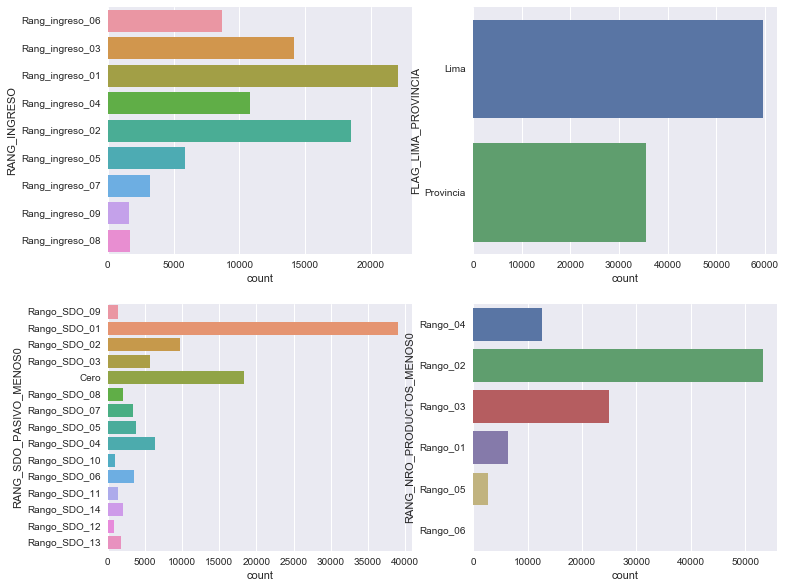

In [8]:
#Resizing levels of categorical variables

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_count(columns, df):
    f, axs = plt.subplots(2, 2, figsize=(12,10))
    n_cols = 1
    i = 0
    j = 0
    for c in columns:
        if j > n_cols:
            j = 0
            i += 1
        #sns.countplot(data=df, y=c, ax=axs[i, j], hue='ATTRITION');
        sns.countplot(data=df, y=c, ax=axs[i, j]);
        j += 1

plot_count(cat_cols, df)

In [9]:
from collections import Counter as cn

def feat_extraction(col, n_feat, df):
    mc = cn(df[col]).most_common(n_feat-1)
    d = df[col].apply(lambda x: 'Otros' if x not in [v[0] for v in mc] else x)
    dd = pd.get_dummies(d, prefix=col, prefix_sep='__')
    return dd

# Concatenate sub df dummies

dm1 = feat_extraction(cat_cols[0], 9, df)
dm2 = feat_extraction(cat_cols[1], 2, df)
dm3 = feat_extraction(cat_cols[2], 15, df)
dm4 = feat_extraction(cat_cols[3], 6, df)

df_ = reduce(lambda x, y: x.join(y), [df, dm1, dm2, dm3, dm4])
df_.drop(cat_cols, inplace=True, axis=1)
df_.head(5)

,CODMES,FLG_BANCARIZADO,EDAD,ANTIGUEDAD,SDO_ACTIVO_MENOS0,SDO_ACTIVO_MENOS1,SDO_ACTIVO_MENOS2,SDO_ACTIVO_MENOS3,SDO_ACTIVO_MENOS4,SDO_ACTIVO_MENOS5,...,RANG_SDO_PASIVO_MENOS0__Rango_SDO_10,RANG_SDO_PASIVO_MENOS0__Rango_SDO_11,RANG_SDO_PASIVO_MENOS0__Rango_SDO_13,RANG_SDO_PASIVO_MENOS0__Rango_SDO_14,RANG_NRO_PRODUCTOS_MENOS0__Otros,RANG_NRO_PRODUCTOS_MENOS0__Rango_01,RANG_NRO_PRODUCTOS_MENOS0__Rango_02,RANG_NRO_PRODUCTOS_MENOS0__Rango_03,RANG_NRO_PRODUCTOS_MENOS0__Rango_04,RANG_NRO_PRODUCTOS_MENOS0__Rango_05
ID_CORRELATIVO,,,,,,,,,,,,,,,,,,,,,
35653,201208,1,25.0,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
66575,201208,1,27.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
56800,201208,1,34.0,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8410,201208,1,63.0,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6853,201208,1,25.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# Working with requeriments file

replace_miss_val(['DICTAMEN'], df_train_req) #there is one null value in DICTAMEN feature

In [11]:
# ver si attrition tiene relacion directa con 'no procede' 

def transform_df_req(df):
    
    t1 = pd.pivot_table(df, 
               index='ID_CORRELATIVO',
               columns='TIPO_REQUERIMIENTO2',
               aggfunc='count',
               fill_value=0)['DICTAMEN']
    
    t2 = pd.pivot_table(df, 
               index='ID_CORRELATIVO',
               columns='TIPO_REQUERIMIENTO2',
               fill_value=0,
               aggfunc={'DICTAMEN': lambda x: sum(map((lambda x: 1 if x in ['PROCEDE TOTAL'] else 0), x))})['DICTAMEN']
    
    # t3 =  seleccionar prod_servicio y submotivo
    
    df_transf = pd.DataFrame(index=t1.index, 
                             data={'Reclamos': t1['Reclamo'], 
                                   'Solicitudes': t1['Solicitud'],
                                   'Rec_proceden': t2['Reclamo'],
                                   'Solic_proceden': t2['Solicitud']})
    
    
    return df_transf # already have index correlative

In [12]:
nx_train_req = transform_df_req(df_train_req)
nx_test_req = transform_df_req(df_test_req)

In [19]:
nx_train = df_.iloc[0:70000]
nx_test = df_.iloc[70000:]
nx_train = pd.concat([nx_train, nx_train_req], axis=1)
nx_test = pd.concat([nx_test, nx_test_req], axis=1)

In [21]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [23]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(nx_train, y_train, test_size=0.25)

In [24]:
dtrain = xgb.DMatrix(x_train_train, label=y_train_train)
dtest = xgb.DMatrix(x_train_test, label=y_train_test)

In [28]:
params = {
    #'max_depth':6,
    #'min_child_weight': 1,
    #'eta':.3,
    #'subsample': 1,
    #'colsample_bytree': 1,
    'objective':'binary:logistic',
    'eval_metric':'logloss'
}

In [29]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-logloss:0.572434
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.510056
[2]	Test-logloss:0.476013
[3]	Test-logloss:0.457238
[4]	Test-logloss:0.447122
[5]	Test-logloss:0.442137
[6]	Test-logloss:0.439345
[7]	Test-logloss:0.437924
[8]	Test-logloss:0.437634
[9]	Test-logloss:0.437512
[10]	Test-logloss:0.437575
[11]	Test-logloss:0.437515
[12]	Test-logloss:0.437417
[13]	Test-logloss:0.437702
[14]	Test-logloss:0.437918
[15]	Test-logloss:0.43809
[16]	Test-logloss:0.438263
[17]	Test-logloss:0.438377
[18]	Test-logloss:0.438603
[19]	Test-logloss:0.43861
[20]	Test-logloss:0.43873
[21]	Test-logloss:0.438706
[22]	Test-logloss:0.43894
Stopping. Best iteration:
[12]	Test-logloss:0.437417



In [27]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'logloss'},
    early_stopping_rounds=10
)

cv_results

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
0,0.570687,0.000652,0.570298,0.000385
1,0.507195,0.001191,0.505998,0.000557
2,0.472184,0.001635,0.470015,0.000869
3,0.452714,0.001889,0.449406,0.000732
4,0.441897,0.002197,0.437314,0.000850
5,0.436155,0.002458,0.430271,0.000779
6,0.433104,0.002693,0.426234,0.000807
7,0.431570,0.002849,0.423422,0.001017
8,0.430945,0.002849,0.421431,0.000787
9,0.430736,0.002927,0.419858,0.000687


In [47]:
#Predicting

y_pred = model.predict(xgb.DMatrix(nx_test))
y_pred = np.where(y_pred > 0.5, 1 , 0)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
submission = pd.DataFrame({'ID_CORRELATIVO': nx_test.index, 'ATTRITION': y_pred})
submission.head()

,ATTRITION,ID_CORRELATIVO
0,0,47411
1,0,39861
2,0,38898
3,0,50927
4,0,32969


In [62]:
submission.to_csv('./data/submission1.csv', index=False)